In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# For use on local machine
%cd ..

C:\Users\efurst1\PycharmProjects\ERM_GDRO


# Results Visualization

Data loading and plotting functions to visualize the results given by run.py  
Put the path of the folder containing the results in load_dir and run the cells to see results

## Defining functions & parameters

In [667]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# .csv to load results from
load_path = 'C:\\Users\\efurst1\\test_results\\cris_all.csv' #'test_results/mnist_independent/accuracies.csv'

In [668]:
# Get train set subclass sizes for waterbirds and find correction factors for the overall accuracy
metadata = pd.read_csv('data/waterbirds_v1.0/metadata.csv')
correction = np.array(metadata[metadata['split'] == 0].groupby(['y', 'place']).size(), dtype=np.float64)
correction /= sum(correction)
correction

array([0.72950991, 0.03837331, 0.01167883, 0.22043796])

In [672]:
def plot_acc(drop_epochs=[], err_margin=0, accuracy_correction=None):
    results_df = pd.read_csv(load_path, index_col=["trial", "epoch", "subtype"])
    if accuracy_correction is not None:
        all_but_overall = results_df.stack().unstack(level=2).drop(columns="Overall")
        corrected_overall = (all_but_overall * accuracy_correction).sum(axis=1)
        all_but_overall['Overall'] = corrected_overall.values
        results_df = all_but_overall.stack().unstack(level=2)
    
    N = max(results_df.index.get_level_values(0)) + 1
    algorithms = results_df.columns
    
    trial_means = results_df.stack().unstack(level=0).mean(axis=1).unstack(level=2)
    trial_errs = results_df.stack().unstack(level=0).std(axis=1).unstack(level=2) / (N ** 0.5)

    trial_means.drop(drop_epochs, level=0, axis=0, inplace=True)
    hide = []
    
    subtypes = ["Overall", "0", "1", "2", "3"]
    subtype_names = ["Overall", "Landbird on Land", "Landbird on Water", "Waterbird on Land", "Waterbird on Water"]
    # subtype_names = ["Overall", "Worst Group"]
    
    f = plt.figure(figsize=(24,12))
    
    grid = plt.GridSpec(2, 4, wspace=0.2, hspace=0.2)
    a = [
        f.add_subplot(grid[:, :2]),
        f.add_subplot(grid[0, 2]),
        f.add_subplot(grid[0, 3]),
        f.add_subplot(grid[1, 2]),
        f.add_subplot(grid[1, 3])
    ]

    # plot subtypes sensitivity

    for i in range(len(subtypes)):
        plot_data = trial_means.drop(columns=hide).xs(subtypes[i], level=1)
        plot_data.plot(title=subtype_names[i],ylim=[0.48,1.02],xlabel="Epoch",ylabel="Accuracy" if subtypes[i] == 'Overall' else 'Sensitivity',kind='line',ax=a[i],grid=True,linewidth=0.5)
        plot_errs = trial_errs.drop(columns=hide).xs(key=subtypes[i], level=1)
        a[i].axvline(x=5, linestyle='dashed', linewidth=1, color='black')
        for col in plot_data.columns:
            a[i].fill_between(list(plot_data.index), plot_data[col] + err_margin * plot_errs[col], plot_data[col] - err_margin * plot_errs[col], alpha=0.25)
        

In [673]:
# statisitical tests comparing to ERM
from scipy.stats import ttest_ind

def ttest(p_threshold=0.05):
    print(f't-tests with significance threshold p<{p_threshold}\n')
    ttest_dataframes = {}

    loaded_accuracies = pd.read_csv(load_path)
    N = max(loaded_accuracies["trial"]) + 1
    epochs = max(loaded_accuracies["epoch"]) + 1
    subtypes = list(loaded_accuracies["subtype"].unique())
    algorithms = loaded_accuracies.columns

    results = loaded_accuracies.drop(columns=["subtype", "epoch", "trial"]).to_dict('list')
    results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

    for s in range(len(subtypes)):
        epoch = epochs - 1

        subtype_data = results_df.xs(subtypes[s], level=2).xs(epoch, level=1)
        erm_data = subtype_data["ERMLoss"].values

        print(subtypes[s])
        for algorithm in results_df.columns:
            if algorithm != "ERMLoss":
                algorithm_data = subtype_data[algorithm].values
                stat, p = ttest_ind(algorithm_data, erm_data)

                print(f'ERMLoss: {erm_data.mean():.3f}, 1.96*stdErr: {(1.96 * erm_data.std(ddof=1) / (len(erm_data) ** 0.5)):.2e}')
                print(f'{algorithm}: {algorithm_data.mean():.3f}, 1.96*stdErr: {(1.96 * algorithm_data.std(ddof=1) / (len(algorithm_data) ** 0.5)):.2e}')
                if p < p_threshold:
                    print(f'{algorithm if stat > 0 else "ERMLoss"} greater with p = {p:.2e}')
                else:
                    print(f'No significant difference with p = {p:.2e}')
                print()

## Show results

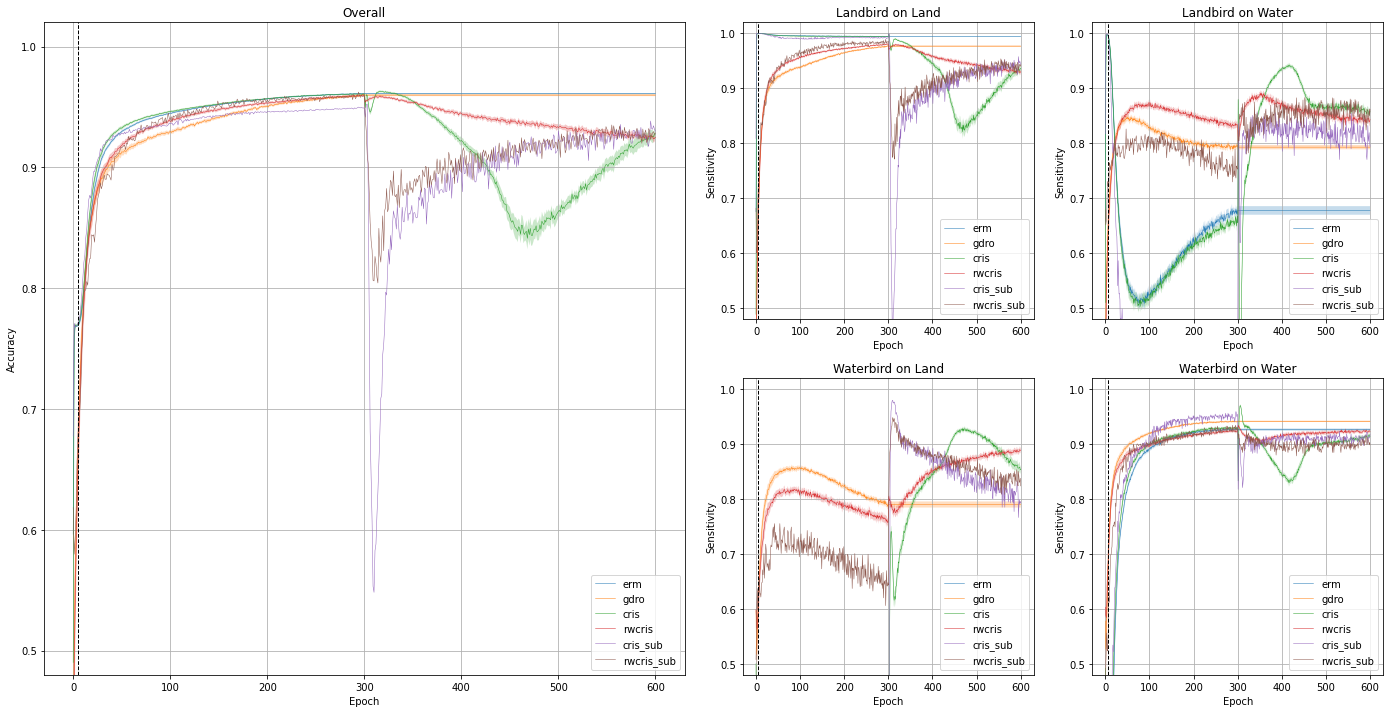

In [674]:
plot_acc(err_margin=1.96, accuracy_correction=correction)

In [685]:
results_df = pd.read_csv(load_path, index_col=["trial", "epoch", "subtype"])
all_but_overall = results_df.stack().unstack(level=2).drop(columns="Overall")
corrected_overall = (all_but_overall * correction).sum(axis=1)
all_but_overall['Overall'] = corrected_overall.values
results_df = all_but_overall.stack().unstack(level=2)

In [686]:
best_epochs = {
    'erm': [298, 298, 300, 296, 298, 296, 297, 297, 284, 297, 289, 297, 298, 299, 298, 299, 296, 290, 287, 298],
    'gdro': [103, 74, 85, 55, 56, 55, 92, 62, 64, 83, 73, 56, 133, 60, 79, 87, 82, 77, 74, 51],
    'cris': [514, 488, 524, 470, 441, 507, 498, 516, 514, 524, 451, 512, 493, 517, 463, 498, 449, 521, 436, 529],
    'rwcris': [502, 569, 436, 586, 534, 500, 559, 531, 420, 587, 405, 557, 600, 577, 590, 530, 516, 561, 446, 547]
}
# best_epochs = {
#     'cris': [6]
# }

In [711]:
# optimistic worst-group
results_df['rwcris_sub'].unstack(level=2).min(axis=1).unstack(level=1).max(axis=1).mean()

0.875388027

In [712]:
# optimistic overall
(results_df['rwcris_sub'].unstack(level=2).iloc[:, :-1] * correction).sum(axis=1).unstack(level=1).max(axis=1).mean()

0.9623822746435872

erm
Worst: 0.4418224298
Overall: 0.9612183991524923

gdro
Worst: 0.8369844791000001
Overall: 0.9204288018653596

cris
Worst: 0.8715283448
Overall: 0.8783932124065588

rwcris
Worst: 0.8584009573000001
Overall: 0.9342305212872262



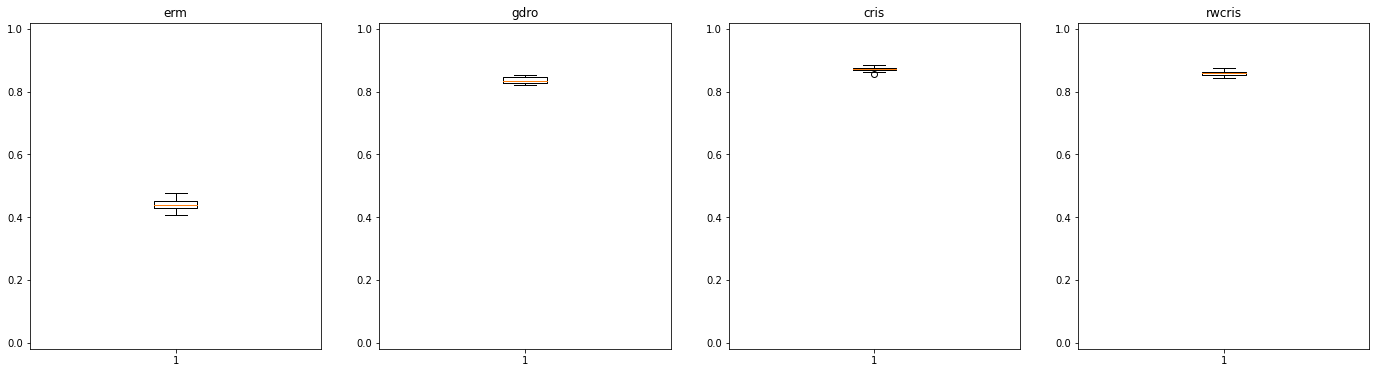

In [699]:
# from best val epoch
f, a = plt.subplots(1, 4)
f.set_figwidth(24)
f.set_figheight(6)
for l in range(4):
    loss = ['erm', 'gdro', 'cris', 'rwcris'][l]
    worst_data = [results_df[loss].xs(level='trial', key=i).xs(level='epoch', key=best_epochs[loss][i]).values.min() for i in range(20)]
    overall_data = [(results_df[loss].xs(level='trial', key=i).xs(level='epoch', key=best_epochs[loss][i]).values[:-1] * correction).sum() for i in range(20)]
    a[l].set_title(loss)
    a[l].set_ylim(-0.02, 1.02)
    a[l].boxplot(worst_data)
    print(loss)
    print(f'Worst: {np.mean(worst_data)}')
    print(f'Overall: {np.mean(overall_data)}')
    print()


In [417]:
eg = pd.read_csv('C:\\Users\\efurst1\\test_results\\test.csv', index_col=['trial', 'epoch', 'subtype'])
eg

erm      gdro
trial epoch subtype                    
0     0     Overall  0.773214  0.773904
            0        0.984035  0.986696
            1        0.996896  0.997339
            2        0.020249  0.014019
            3        0.000000  0.001558
...                       ...       ...
19    300   Overall  0.804798  0.875561
            0        0.995565  0.974279
            1        0.692683  0.782262
            2        0.404984  0.791277
            3        0.928349  0.940810

[30100 rows x 2 columns]

In [420]:
eg.stack().unstack(level=1)[300]

trial  subtype      
0      0        erm     0.995122
                gdro    0.976940
       1        erm     0.670510
                gdro    0.794678
       2        erm     0.457944
                          ...   
19     2        gdro    0.791277
       3        erm     0.928349
                gdro    0.940810
       Overall  erm     0.804798
                gdro    0.875561
Name: 300, Length: 200, dtype: float64

In [421]:
pad_data = {}
for i in range(301, 601):
    pad_data[i] = egstacked[300]
pad_df = pd.DataFrame.from_dict(pad_data)
pad_df.columns.rename('epoch', inplace=True)
pad_df

epoch                    301       302       303       304       305  \
trial subtype                                                          
0     0       erm   0.995122  0.995122  0.995122  0.995122  0.995122   
              gdro  0.976940  0.976940  0.976940  0.976940  0.976940   
      1       erm   0.670510  0.670510  0.670510  0.670510  0.670510   
              gdro  0.794678  0.794678  0.794678  0.794678  0.794678   
      2       erm   0.457944  0.457944  0.457944  0.457944  0.457944   
...                      ...       ...       ...       ...       ...   
19    2       gdro  0.791277  0.791277  0.791277  0.791277  0.791277   
      3       erm   0.928349  0.928349  0.928349  0.928349  0.928349   
              gdro  0.940810  0.940810  0.940810  0.940810  0.940810   
      Overall erm   0.804798  0.804798  0.804798  0.804798  0.804798   
              gdro  0.875561  0.875561  0.875561  0.875561  0.875561   

epoch                    306       307       308       309       310  ...  \
trial subtype                                                         ...   
0     0       erm   0.995122  0.995122  0.995122  0.995122  0.995122  ...   
              gdro  0.976940  0.976940  0.976940  0.976940  0.976940  ...   
      1       erm   0.670510  0.670510  0.670510  0.670510  0.670510  ...   
              gdro  0.794678  0.794678  0.794678  0.794678  0.794678  ...   
      2       erm   0.457944  0.457944  0.457944  0.457944  0.457944  ...   
...                      ...       ...       ...       ...       ...  ...   
19    2       gdro  0.791277  0.791277  0.791277  0.791277  0.791277  ...   
      3       erm   0.928349  0.928349  0.928349  0.928349  0.928349  ...   
              gdro  0.940810  0.940810  0.940810  0.940810  0.940810  ...   
      Overall erm   0.804798  0.804798  0.804798  0.804798  0.804798  ...   
              gdro  0.875561  0.875561  0.875561  0.875561  0.875561  ...   

epoch                    591       592       593       594       595  \
trial subtype                                                          
0     0       erm   0.995122  0.995122  0.995122  0.995122  0.995122   
              gdro  0.976940  0.976940  0.976940  0.976940  0.976940   
      1       erm   0.670510  0.670510  0.670510  0.670510  0.670510   
              gdro  0.794678  0.794678  0.794678  0.794678  0.794678   
      2       erm   0.457944  0.457944  0.457944  0.457944  0.457944   
...                      ...       ...       ...       ...       ...   
19    2       gdro  0.791277  0.791277  0.791277  0.791277  0.791277   
      3       erm   0.928349  0.928349  0.928349  0.928349  0.928349   
              gdro  0.940810  0.940810  0.940810  0.940810  0.940810   
      Overall erm   0.804798  0.804798  0.804798  0.804798  0.804798   
              gdro  0.875561  0.875561  0.875561  0.875561  0.875561   

epoch                    596       597       598       599       600  
trial subtype                                                         
0     0       erm   0.995122  0.995122  0.995122  0.995122  0.995122  
              gdro  0.976940  0.976940  0.976940  0.976940  0.976940  
      1       erm   0.670510  0.670510  0.670510  0.670510  0.670510  
              gdro  0.794678  0.794678  0.794678  0.794678  0.794678  
      2       erm   0.457944  0.457944  0.457944  0.457944  0.457944  
...                      ...       ...       ...       ...       ...  
19    2       gdro  0.791277  0.791277  0.791277  0.791277  0.791277  
      3       erm   0.928349  0.928349  0.928349  0.928349  0.928349  
              gdro  0.940810  0.940810  0.940810  0.940810  0.940810  
      Overall erm   0.804798  0.804798  0.804798  0.804798  0.804798  
              gdro  0.875561  0.875561  0.875561  0.875561  0.875561  

[200 rows x 300 columns]

In [422]:
paddedstacked = pd.concat([eg.stack().unstack(level=1), pd.DataFrame(pad_df)], axis=1)
paddedstacked

epoch                    0         1         2         3         4    \
trial subtype                                                          
0     0       erm   0.984035  1.000000  1.000000  1.000000  1.000000   
              gdro  0.986696  0.819956  0.525499  0.409313  0.426608   
      1       erm   0.996896  1.000000  1.000000  1.000000  1.000000   
              gdro  0.997339  0.892239  0.618625  0.492239  0.483814   
      2       erm   0.020249  0.000000  0.000000  0.000000  0.000000   
...                      ...       ...       ...       ...       ...   
19    2       gdro  0.524922  0.400312  0.390966  0.431464  0.445483   
      3       erm   0.082555  0.003115  0.000000  0.000000  0.001558   
              gdro  0.887850  0.669782  0.677570  0.705607  0.716511   
      Overall erm   0.710563  0.777183  0.778219  0.778219  0.778391   
              gdro  0.379358  0.477908  0.545564  0.578875  0.619952   

epoch                    5         6         7         8         9    ...  \
trial subtype                                                         ...   
0     0       erm   1.000000  1.000000  1.000000  1.000000  1.000000  ...   
              gdro  0.473614  0.547672  0.619956  0.684701  0.709534  ...   
      1       erm   1.000000  1.000000  0.999557  0.999557  0.999557  ...   
              gdro  0.509534  0.563636  0.623503  0.661197  0.680710  ...   
      2       erm   0.000000  0.000000  0.000000  0.001558  0.001558  ...   
...                      ...       ...       ...       ...       ...  ...   
19    2       gdro  0.493769  0.514019  0.556075  0.598131  0.609034  ...   
      3       erm   0.003115  0.006231  0.010903  0.024922  0.043614  ...   
              gdro  0.742991  0.757009  0.785047  0.799065  0.805296  ...   
      Overall erm   0.778564  0.778564  0.778391  0.778737  0.778564  ...   
              gdro  0.647912  0.678806  0.692440  0.714877  0.738350  ...   

epoch                    591       592       593       594       595  \
trial subtype                                                          
0     0       erm   0.995122  0.995122  0.995122  0.995122  0.995122   
              gdro  0.976940  0.976940  0.976940  0.976940  0.976940   
      1       erm   0.670510  0.670510  0.670510  0.670510  0.670510   
              gdro  0.794678  0.794678  0.794678  0.794678  0.794678   
      2       erm   0.457944  0.457944  0.457944  0.457944  0.457944   
...                      ...       ...       ...       ...       ...   
19    2       gdro  0.791277  0.791277  0.791277  0.791277  0.791277   
      3       erm   0.928349  0.928349  0.928349  0.928349  0.928349   
              gdro  0.940810  0.940810  0.940810  0.940810  0.940810   
      Overall erm   0.804798  0.804798  0.804798  0.804798  0.804798   
              gdro  0.875561  0.875561  0.875561  0.875561  0.875561   

epoch                    596       597       598       599       600  
trial subtype                                                         
0     0       erm   0.995122  0.995122  0.995122  0.995122  0.995122  
              gdro  0.976940  0.976940  0.976940  0.976940  0.976940  
      1       erm   0.670510  0.670510  0.670510  0.670510  0.670510  
              gdro  0.794678  0.794678  0.794678  0.794678  0.794678  
      2       erm   0.457944  0.457944  0.457944  0.457944  0.457944  
...                      ...       ...       ...       ...       ...  
19    2       gdro  0.791277  0.791277  0.791277  0.791277  0.791277  
      3       erm   0.928349  0.928349  0.928349  0.928349  0.928349  
              gdro  0.940810  0.940810  0.940810  0.940810  0.940810  
      Overall erm   0.804798  0.804798  0.804798  0.804798  0.804798  
              gdro  0.875561  0.875561  0.875561  0.875561  0.875561  

[200 rows x 601 columns]

In [441]:
padded = paddedstacked.unstack().unstack(level=1).stack(level=0).stack(level=1)
# padded.index = padded.index.set_levels(['Overall', 0, 1, 2, 3], level=2)
newdf = padded.copy()
newdf.iloc[0::5,:] = padded.iloc[4::5,:]
newdf.iloc[1::5,:] = padded.iloc[0::5,:]
newdf.iloc[2::5,:] = padded.iloc[1::5,:]
newdf.iloc[3::5,:] = padded.iloc[2::5,:]
newdf.iloc[4::5,:] = padded.iloc[3::5,:]
newdf.index = newdf.index.set_levels(['Overall', 0, 1, 2, 3], level=2)
newdf

erm      gdro
trial epoch subtype                    
0     0     Overall  0.773214  0.773904
            0        0.984035  0.986696
            1        0.996896  0.997339
            2        0.020249  0.014019
            3        0.000000  0.001558
...                       ...       ...
19    600   Overall  0.804798  0.875561
            0        0.995565  0.974279
            1        0.692683  0.782262
            2        0.404984  0.791277
            3        0.928349  0.940810

[60100 rows x 2 columns]

In [443]:
newdf.to_csv('C:\\Users\\efurst1\\test_results\\padded.csv')

In [554]:
multi = pd.read_csv('C:\\Users\\efurst1\\test_results\\cris_multi.csv', index_col=['trial', 'epoch', 'subtype'])

In [556]:
multi_expanded = pd.concat([multi] * 20)

In [563]:
multi_expanded.index = pd.MultiIndex.from_product([range(20), range(601), ['Overall', '0', '1', '2', '3']], names=['trial', 'epoch', 'subtype'])
multi_expanded

cris_sub  rwcris_sub
trial epoch subtype                      
0     0     Overall  0.685192    0.630652
            0        0.808869    0.681596
            1        0.817295    0.678936
            2        0.228972    0.507788
            3        0.242991    0.404984
...                       ...         ...
19    600   Overall  0.865723    0.893165
            0        0.943237    0.942794
            1        0.794235    0.861641
            2        0.792835    0.823988
            3        0.917445    0.898754

[60100 rows x 2 columns]

In [564]:
multi_expanded.to_csv('C:\\Users\\efurst1\\test_results\\cris_multi_repeated20.csv')